# Steven VanOmmeren
# Week 12 Coding Assignment 1

STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

# GAN Trained on MNIST

## Imports

In [3]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Classes/01 Spring 2025/AI Algo II/homework-week-12')

Mounted at /content/gdrive


#### Import utility functions

In [5]:
from helper_data import get_dataloaders_mnist
from helper_train import train_gan_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_multiple_training_losses
from helper_plotting import plot_generated_images

In [6]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
#DEVICE = torch.device('cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 100
BATCH_SIZE = 128

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 28, 28, 1

Device: cuda:0


In [7]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

# Problem 2.
Change the code to merge the train and test portions of MNIST datasets into a single dataset to use in training the GAN.

In [8]:
##########################
### Dataset
##########################

from torchvision import datasets
from torch.utils.data import DataLoader

custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=custom_transforms,
                               download=True)

print(f"\nOriginal train dataset size: {len(train_dataset)}.")

# NEW: Load the test dataset
test_dataset = datasets.MNIST(root='data',
                               train=False,
                               transform=custom_transforms,
                               download=True)

# NEW: Merge train and test datasets
train_dataset.data = torch.cat((train_dataset.data, test_dataset.data), dim=0)
train_dataset.targets = torch.cat((train_dataset.targets, test_dataset.targets), dim=0)

print(f"Combined dataset size: {len(train_dataset)}.")

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.20MB/s]


Original train dataset size: 60000.
Combined dataset size: 70000.
Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [9]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


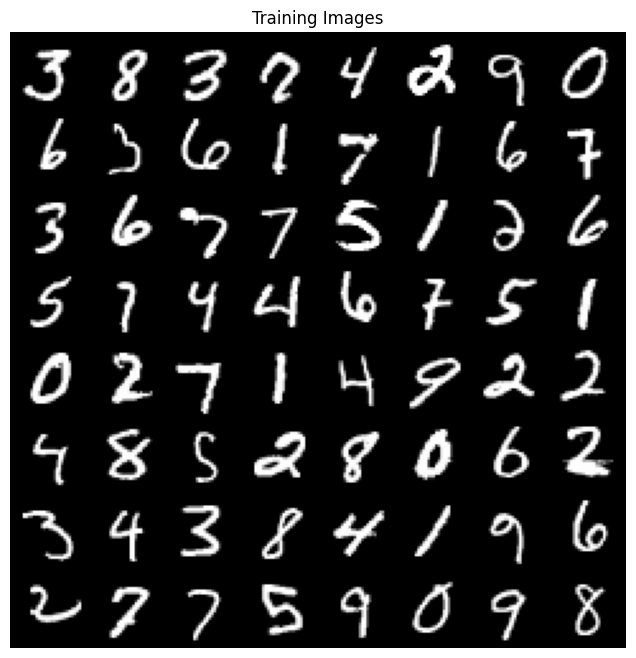

In [10]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64],
                                         padding=2, normalize=True),
                        (1, 2, 0)))
plt.show()

## Model

In [11]:
##########################
### MODEL
##########################

class GAN(torch.nn.Module):

    def __init__(self, latent_dim=100,
                 image_height=28, image_width=28, color_channels=1):
        super().__init__()

        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels

        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, image_height*image_width*color_channels),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_height*image_width*color_channels, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1), # outputs logits
            #nn.Sigmoid()
        )

    def generator_forward(self, z):# z has dimension NCHW
        z = torch.flatten(z, start_dim=1)
        img = self.generator(z)
        img = img.view(z.size(0),
                       self.color_channels,
                       self.image_height,
                       self.image_width)
        return img

    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits

In [12]:
set_all_seeds(RANDOM_SEED)

model = GAN()
model.to(DEVICE)


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

Building a helper function that accepts different parameters for Problem 3:
- dropout: fraction of parameters that are turned off during training.
- use_Adam: if True, use Adam optimizer. If False, use SGD optimizer.
- learning_rate: learning rate for Adam optimizer.

The defaults are set to match the original model from this notebook.

In [13]:
def training_routine(
        dropout=0.5,
        use_Adam=True,
        learning_rate_gen=GENERATOR_LEARNING_RATE,
        learning_rate_dis=DISCRIMINATOR_LEARNING_RATE,
        num_epochs=NUM_EPOCHS,
        latent_dim=100,
        logging_interval=100,
        model_name=None
    ):
    # Define a model name based on the chosen hyperparameters
    if model_name is None:
        model_name = f'gan_mnist_dr{dropout}_adam{use_Adam}_lrg{learning_rate_gen}_lrd{learning_rate_dis}.pt'

    # Define the models
    class GAN(torch.nn.Module):
        def __init__(self, latent_dim=latent_dim,
                    image_height=28, image_width=28, color_channels=1):
            super().__init__()
            self.image_height = image_height
            self.image_width = image_width
            self.color_channels = color_channels
            self.generator = nn.Sequential(
                nn.Linear(latent_dim, 128),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(p=dropout),
                nn.Linear(128, image_height*image_width*color_channels),
                nn.Tanh()
            )
            self.discriminator = nn.Sequential(
                nn.Flatten(),
                nn.Linear(image_height*image_width*color_channels, 128),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(p=dropout),
                nn.Linear(128, 1), # outputs logits
            )
        def generator_forward(self, z):# z has dimension NCHW
            z = torch.flatten(z, start_dim=1)
            img = self.generator(z)
            img = img.view(z.size(0),
                        self.color_channels,
                        self.image_height,
                        self.image_width)
            return img
        def discriminator_forward(self, img):
            logits = model.discriminator(img)
            return logits

    # Setup the model
    set_all_seeds(RANDOM_SEED)
    model = GAN()
    model.to(DEVICE)

    if use_Adam:
        optim_gen = torch.optim.Adam(model.generator.parameters(),
                                    betas=(0.5, 0.999),
                                    lr=learning_rate_gen)

        optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                                    betas=(0.5, 0.999),
                                    lr=learning_rate_dis)
    else:
        optim_gen = torch.optim.SGD(model.generator.parameters(),
                                    lr=learning_rate_gen)

        optim_discr = torch.optim.SGD(model.discriminator.parameters(),
                                    lr=learning_rate_dis)

    log_dict = train_gan_v1(num_epochs=num_epochs, model=model,
                    optimizer_gen=optim_gen,
                    optimizer_discr=optim_discr,
                    latent_dim=latent_dim,
                    device=DEVICE,
                    train_loader=train_loader,
                    logging_interval=logging_interval,
                    save_model=model_name)

    return log_dict

# Problem 3.
By using the GAN output image quality as a proxy, examine whether: (a) using dropout regularization makes a difference, (b) SGD or Adam optimizer performs better, (c) identifying the best learning rates in the Adam optimizer.

## Note
I change the following settings compared to the original notebook:
- number of epochs: ~~100~~ 50

In [14]:
n_epochs=50
latent=100

In [15]:
model_1 = training_routine(
        dropout=0.5,
        use_Adam=True,
        learning_rate_gen=GENERATOR_LEARNING_RATE,
        learning_rate_dis=DISCRIMINATOR_LEARNING_RATE,
        num_epochs=n_epochs,
        latent_dim=latent,
        logging_interval=547, # 1 output per epoch
        model_name=None
    )

Epoch: 001/050 | Batch 000/547 | Gen/Dis Loss: 0.7361/0.6865
Time elapsed: 0.28 min
Epoch: 002/050 | Batch 000/547 | Gen/Dis Loss: 1.0746/0.3882
Time elapsed: 0.55 min
Epoch: 003/050 | Batch 000/547 | Gen/Dis Loss: 0.9676/0.4492
Time elapsed: 0.82 min
Epoch: 004/050 | Batch 000/547 | Gen/Dis Loss: 1.1329/0.4976
Time elapsed: 1.09 min
Epoch: 005/050 | Batch 000/547 | Gen/Dis Loss: 1.2671/0.4712
Time elapsed: 1.36 min
Epoch: 006/050 | Batch 000/547 | Gen/Dis Loss: 1.1245/0.4851
Time elapsed: 1.62 min
Epoch: 007/050 | Batch 000/547 | Gen/Dis Loss: 1.1196/0.5007
Time elapsed: 1.88 min
Epoch: 008/050 | Batch 000/547 | Gen/Dis Loss: 1.1283/0.5296
Time elapsed: 2.14 min
Epoch: 009/050 | Batch 000/547 | Gen/Dis Loss: 1.1830/0.5379
Time elapsed: 2.40 min
Epoch: 010/050 | Batch 000/547 | Gen/Dis Loss: 1.1847/0.4725
Time elapsed: 2.67 min
Epoch: 011/050 | Batch 000/547 | Gen/Dis Loss: 1.1807/0.5256
Time elapsed: 2.93 min
Epoch: 012/050 | Batch 000/547 | Gen/Dis Loss: 1.3471/0.4762
Time elapsed: 3

Part (a) models: testing dropout

In [16]:
model_2 = training_routine(
        dropout=0.1,
        use_Adam=True,
        learning_rate_gen=GENERATOR_LEARNING_RATE,
        learning_rate_dis=DISCRIMINATOR_LEARNING_RATE,
        num_epochs=n_epochs,
        latent_dim=latent,
        logging_interval=547,
        model_name=None
    )

Epoch: 001/050 | Batch 000/547 | Gen/Dis Loss: 0.7310/0.6857
Time elapsed: 0.26 min
Epoch: 002/050 | Batch 000/547 | Gen/Dis Loss: 1.0539/0.3760
Time elapsed: 0.52 min
Epoch: 003/050 | Batch 000/547 | Gen/Dis Loss: 1.2623/0.3693
Time elapsed: 0.77 min
Epoch: 004/050 | Batch 000/547 | Gen/Dis Loss: 1.1494/0.3891
Time elapsed: 1.03 min
Epoch: 005/050 | Batch 000/547 | Gen/Dis Loss: 1.5584/0.4097
Time elapsed: 1.30 min
Epoch: 006/050 | Batch 000/547 | Gen/Dis Loss: 1.4368/0.3880
Time elapsed: 1.56 min
Epoch: 007/050 | Batch 000/547 | Gen/Dis Loss: 1.5096/0.3844
Time elapsed: 1.82 min
Epoch: 008/050 | Batch 000/547 | Gen/Dis Loss: 1.6335/0.3197
Time elapsed: 2.08 min
Epoch: 009/050 | Batch 000/547 | Gen/Dis Loss: 1.4112/0.3830
Time elapsed: 2.34 min
Epoch: 010/050 | Batch 000/547 | Gen/Dis Loss: 1.7909/0.3114
Time elapsed: 2.60 min
Epoch: 011/050 | Batch 000/547 | Gen/Dis Loss: 1.5175/0.3569
Time elapsed: 2.86 min
Epoch: 012/050 | Batch 000/547 | Gen/Dis Loss: 1.6801/0.3933
Time elapsed: 3

In [17]:
model_3 = training_routine(
        dropout=0.9,
        use_Adam=True,
        learning_rate_gen=GENERATOR_LEARNING_RATE,
        learning_rate_dis=DISCRIMINATOR_LEARNING_RATE,
        num_epochs=n_epochs,
        latent_dim=latent,
        logging_interval=547,
        model_name=None
    )

Epoch: 001/050 | Batch 000/547 | Gen/Dis Loss: 0.7363/0.6998
Time elapsed: 0.27 min
Epoch: 002/050 | Batch 000/547 | Gen/Dis Loss: 0.9438/0.4930
Time elapsed: 0.53 min
Epoch: 003/050 | Batch 000/547 | Gen/Dis Loss: 1.0006/0.5037
Time elapsed: 0.80 min
Epoch: 004/050 | Batch 000/547 | Gen/Dis Loss: 0.9485/0.5244
Time elapsed: 1.06 min
Epoch: 005/050 | Batch 000/547 | Gen/Dis Loss: 0.8759/0.5497
Time elapsed: 1.33 min
Epoch: 006/050 | Batch 000/547 | Gen/Dis Loss: 0.8423/0.5847
Time elapsed: 1.59 min
Epoch: 007/050 | Batch 000/547 | Gen/Dis Loss: 0.8402/0.6545
Time elapsed: 1.86 min
Epoch: 008/050 | Batch 000/547 | Gen/Dis Loss: 0.8380/0.6280
Time elapsed: 2.12 min
Epoch: 009/050 | Batch 000/547 | Gen/Dis Loss: 0.8198/0.6422
Time elapsed: 2.38 min
Epoch: 010/050 | Batch 000/547 | Gen/Dis Loss: 0.8869/0.6434
Time elapsed: 2.65 min
Epoch: 011/050 | Batch 000/547 | Gen/Dis Loss: 0.8186/0.6347
Time elapsed: 2.91 min
Epoch: 012/050 | Batch 000/547 | Gen/Dis Loss: 0.8183/0.6415
Time elapsed: 3

Part (b) models: testing SGD/Adam
Model 1 uses Adam, so we just run a similar model with SGD.

In [18]:
model_4 = training_routine(
        dropout=0.5,
        use_Adam=False,
        learning_rate_gen=GENERATOR_LEARNING_RATE,
        learning_rate_dis=DISCRIMINATOR_LEARNING_RATE,
        num_epochs=n_epochs,
        latent_dim=latent,
        logging_interval=547,
        model_name=None
    )

Epoch: 001/050 | Batch 000/547 | Gen/Dis Loss: 0.7287/0.6865
Time elapsed: 0.26 min
Epoch: 002/050 | Batch 000/547 | Gen/Dis Loss: 0.7294/0.4563
Time elapsed: 0.52 min
Epoch: 003/050 | Batch 000/547 | Gen/Dis Loss: 0.7581/0.3800
Time elapsed: 0.78 min
Epoch: 004/050 | Batch 000/547 | Gen/Dis Loss: 0.7900/0.3410
Time elapsed: 1.03 min
Epoch: 005/050 | Batch 000/547 | Gen/Dis Loss: 0.8275/0.3203
Time elapsed: 1.29 min
Epoch: 006/050 | Batch 000/547 | Gen/Dis Loss: 0.8404/0.3036
Time elapsed: 1.55 min
Epoch: 007/050 | Batch 000/547 | Gen/Dis Loss: 0.8707/0.2946
Time elapsed: 1.81 min
Epoch: 008/050 | Batch 000/547 | Gen/Dis Loss: 0.9194/0.2778
Time elapsed: 2.06 min
Epoch: 009/050 | Batch 000/547 | Gen/Dis Loss: 0.9427/0.2587
Time elapsed: 2.32 min
Epoch: 010/050 | Batch 000/547 | Gen/Dis Loss: 1.0020/0.2479
Time elapsed: 2.58 min
Epoch: 011/050 | Batch 000/547 | Gen/Dis Loss: 1.0083/0.2401
Time elapsed: 2.83 min
Epoch: 012/050 | Batch 000/547 | Gen/Dis Loss: 1.0511/0.2304
Time elapsed: 3

Part (c) models: Adam learning rates
We test 2 alternative learning rates:
- Half of original learning rates
- Twice of original learning rates

In [19]:
model_5 = training_routine(
        dropout=0.5,
        use_Adam=True,
        learning_rate_gen=GENERATOR_LEARNING_RATE/2,
        learning_rate_dis=DISCRIMINATOR_LEARNING_RATE/2,
        num_epochs=n_epochs,
        latent_dim=latent,
        logging_interval=547,
        model_name=None
    )

Epoch: 001/050 | Batch 000/547 | Gen/Dis Loss: 0.7324/0.6865
Time elapsed: 0.26 min
Epoch: 002/050 | Batch 000/547 | Gen/Dis Loss: 0.6956/0.5426
Time elapsed: 0.52 min
Epoch: 003/050 | Batch 000/547 | Gen/Dis Loss: 1.0107/0.4174
Time elapsed: 0.78 min
Epoch: 004/050 | Batch 000/547 | Gen/Dis Loss: 1.0442/0.4429
Time elapsed: 1.05 min
Epoch: 005/050 | Batch 000/547 | Gen/Dis Loss: 1.2060/0.4109
Time elapsed: 1.31 min
Epoch: 006/050 | Batch 000/547 | Gen/Dis Loss: 1.0246/0.4869
Time elapsed: 1.58 min
Epoch: 007/050 | Batch 000/547 | Gen/Dis Loss: 1.1340/0.4566
Time elapsed: 1.84 min
Epoch: 008/050 | Batch 000/547 | Gen/Dis Loss: 0.9970/0.4941
Time elapsed: 2.10 min
Epoch: 009/050 | Batch 000/547 | Gen/Dis Loss: 1.1666/0.4883
Time elapsed: 2.36 min
Epoch: 010/050 | Batch 000/547 | Gen/Dis Loss: 1.2090/0.4760
Time elapsed: 2.62 min
Epoch: 011/050 | Batch 000/547 | Gen/Dis Loss: 1.1406/0.4780
Time elapsed: 2.88 min
Epoch: 012/050 | Batch 000/547 | Gen/Dis Loss: 1.1915/0.5026
Time elapsed: 3

In [20]:
model_6 = training_routine(
        dropout=0.5,
        use_Adam=True,
        learning_rate_gen=GENERATOR_LEARNING_RATE*2,
        learning_rate_dis=DISCRIMINATOR_LEARNING_RATE*2,
        num_epochs=n_epochs,
        latent_dim=latent,
        logging_interval=547,
        model_name=None
    )

Epoch: 001/050 | Batch 000/547 | Gen/Dis Loss: 0.7436/0.6865
Time elapsed: 0.26 min
Epoch: 002/050 | Batch 000/547 | Gen/Dis Loss: 0.8775/0.4900
Time elapsed: 0.53 min
Epoch: 003/050 | Batch 000/547 | Gen/Dis Loss: 1.0449/0.5180
Time elapsed: 0.79 min
Epoch: 004/050 | Batch 000/547 | Gen/Dis Loss: 0.9567/0.5239
Time elapsed: 1.06 min
Epoch: 005/050 | Batch 000/547 | Gen/Dis Loss: 0.9649/0.5556
Time elapsed: 1.32 min
Epoch: 006/050 | Batch 000/547 | Gen/Dis Loss: 1.0930/0.5672
Time elapsed: 1.59 min
Epoch: 007/050 | Batch 000/547 | Gen/Dis Loss: 1.1046/0.5244
Time elapsed: 1.85 min
Epoch: 008/050 | Batch 000/547 | Gen/Dis Loss: 1.0056/0.5836
Time elapsed: 2.11 min
Epoch: 009/050 | Batch 000/547 | Gen/Dis Loss: 1.0849/0.5792
Time elapsed: 2.37 min
Epoch: 010/050 | Batch 000/547 | Gen/Dis Loss: 1.1440/0.5164
Time elapsed: 2.64 min
Epoch: 011/050 | Batch 000/547 | Gen/Dis Loss: 1.0556/0.5875
Time elapsed: 2.90 min
Epoch: 012/050 | Batch 000/547 | Gen/Dis Loss: 1.1464/0.5349
Time elapsed: 3

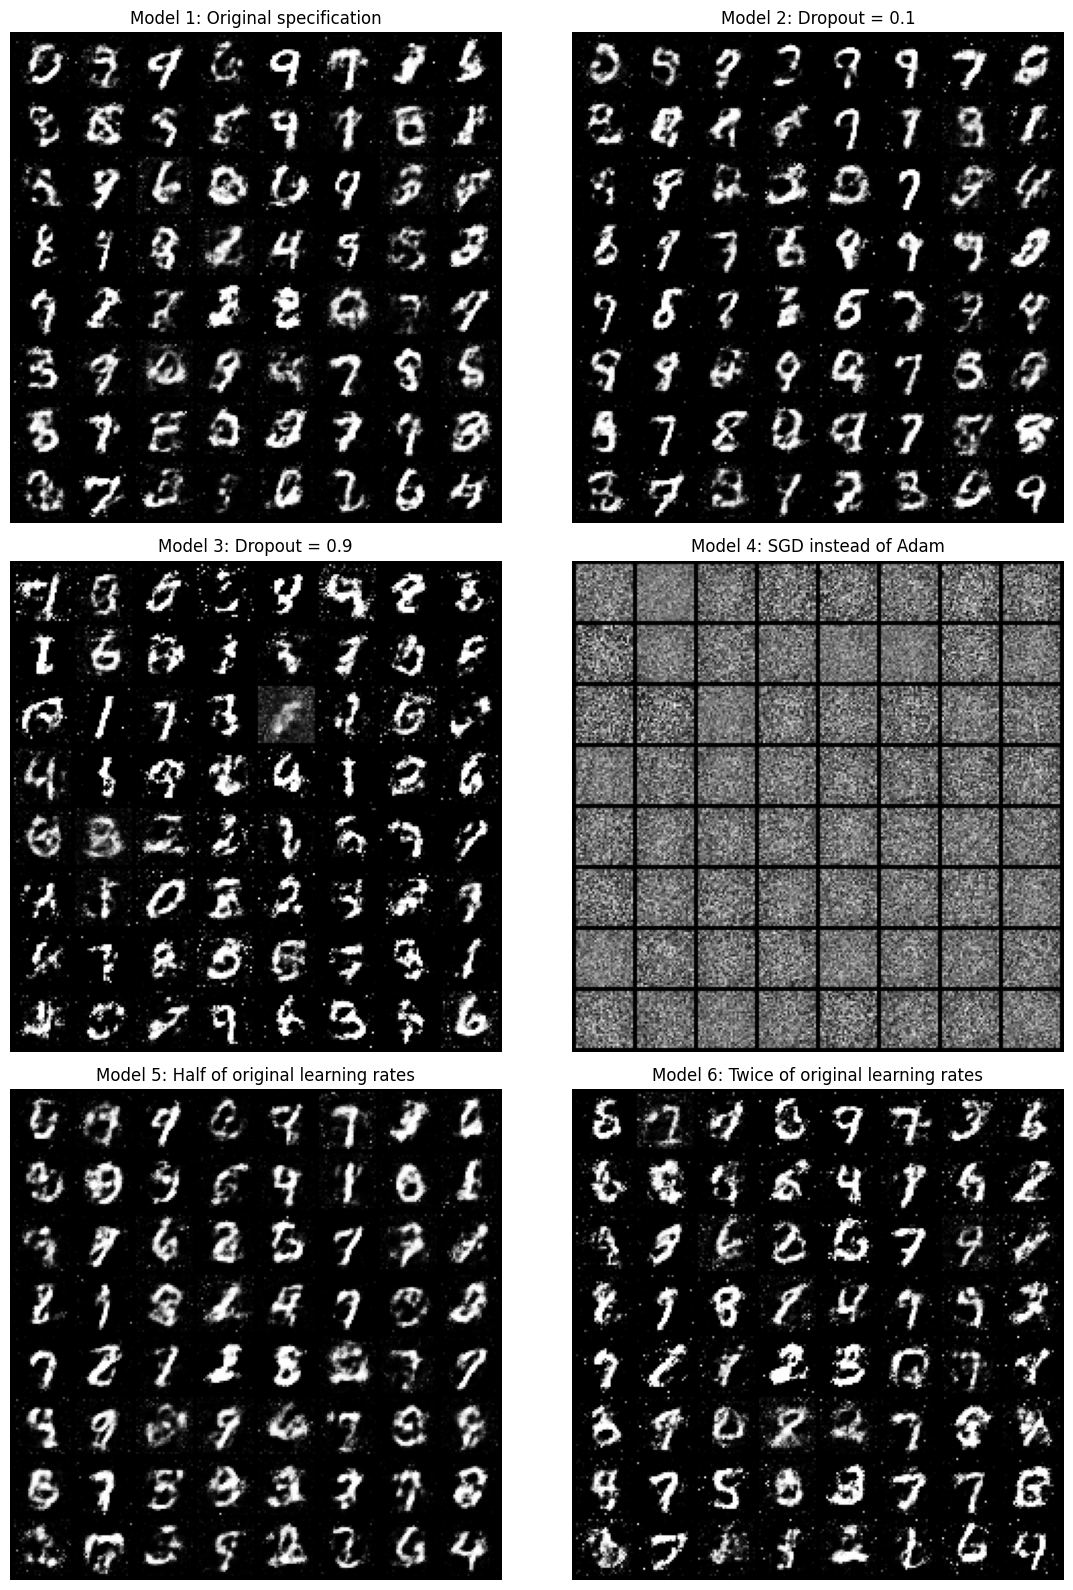

In [21]:
# Now plot everything

# Create a figure with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(12, 16))

# Model titles
titles = [
    "Model 1: Original specification",
    "Model 2: Dropout = 0.1",
    "Model 3: Dropout = 0.9",
    "Model 4: SGD instead of Adam",
    "Model 5: Half of original learning rates",
    "Model 6: Twice of original learning rates"
]

# Models list
models = [model_1, model_2, model_3, model_4, model_5, model_6]

# Plot each model
for idx, (ax, model, title) in enumerate(zip(axes.flatten(), models, titles)):
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(np.transpose(model['images_from_noise_per_epoch'][-1], (1, 2, 0)))

plt.tight_layout()
plt.savefig('model results.png')
plt.show()

Part (a) conclusions:
I ran a model with dropout proportion of 0.1 (keeping only 10%) and 0.9 (keeping 90%). Comparing the output from the 50th training epoch, there is not much of a difference between the two. If anything, some of the output images in the dropout = 0.9 model are a bit sharper, but the output is very similar overall. These results suggest that dropout does not make much of a difference in GANs, perhaps because the discriminator helps to regularize the results of the generator.

Part (b) conclusions:

Part (c) conclusions:

# Problem 4:
Evaluate the extent of mode collapse present across the 9 digits.

